In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt
import tensorflow as tf 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
df=pd.read_csv("ucus.csv")

In [3]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [5]:
df.columns=["Month","Pes"]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   145 non-null    object 
 1   Pes     144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [7]:
df.isnull().sum()

Month    0
Pes      1
dtype: int64

In [8]:
df.tail

<bound method NDFrame.tail of                                                  Month    Pes
0                                              1949-01  112.0
1                                              1949-02  118.0
2                                              1949-03  132.0
3                                              1949-04  129.0
4                                              1949-05  121.0
..                                                 ...    ...
140                                            1960-09  508.0
141                                            1960-10  461.0
142                                            1960-11  390.0
143                                            1960-12  432.0
144  International airline passengers: monthly tota...    NaN

[145 rows x 2 columns]>

In [21]:
df.dropna(inplace=True)
df.head()
df.tail()

,Pes
Month,
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0
1960-11-01,390.0
1960-12-01,432.0


In [56]:
df.tail()


,Pes
Month,
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0
1960-11-01,390.0
1960-12-01,432.0


In [ ]:
result_df=df.copy()

<Axes: title={'center': 'aylara göre ucus'}, xlabel='Month'>

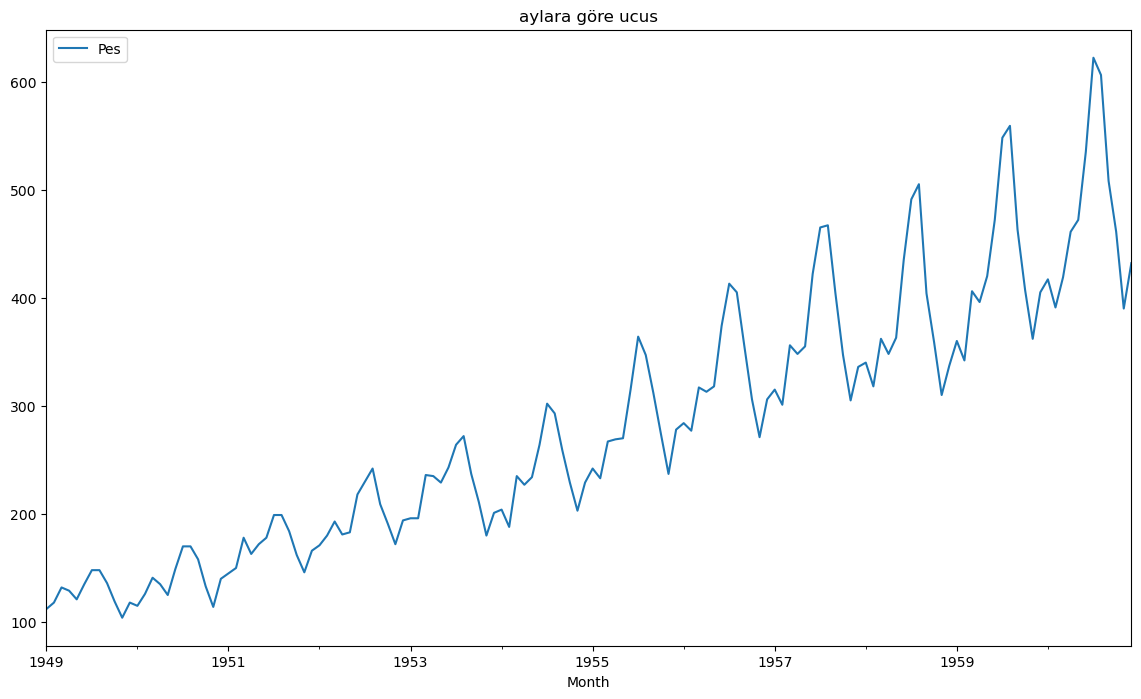

In [58]:
df.plot(figsize=(14,8),title="aylara göre ucus")

In [59]:
data=df["Pes"].values
data=data.astype('float32')
data=data.reshape(-1,1)
data.shape

(144, 1)

In [60]:
def split_data(df,size):
    pos=int(round(len(df)*(1-size)))
    train=df[:pos]
    test=df[pos:]
    return train,test,pos

In [61]:
train,test,pos=split_data(data,0.3)

In [62]:
train.shape,test.shape

((101, 1), (43, 1))

In [63]:
sc_train=MinMaxScaler(feature_range=(0,1))
train=sc_train.fit_transform(train)

In [64]:
sc_test=MinMaxScaler(feature_range=(0,1))
test=sc_test.fit_transform(test)

In [65]:
train[:5],test[:5]

(array([[0.02588999],
        [0.04530746],
        [0.09061491],
        [0.08090615],
        [0.05501619]], dtype=float32),
 array([[0.36908513],
        [0.50473183],
        [0.511041  ],
        [0.31230277],
        [0.13249213]], dtype=float32))

In [66]:
def create_features(data,lookback):
    X,y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        y.append(data[i,0])
    return np.array(X),np.array(y)

In [68]:
lookback=1
X_train,y_train=create_features(train,lookback)

X_test,y_test=create_features(test,lookback)

In [70]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(100, 1) (100,)
(42, 1) (42,)


In [72]:
X_train=X_train.reshape(X_train.shape[0],1,X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],1,X_test.shape[1],1)
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)    

(100, 1, 1, 1) (100, 1)
(42, 1, 1, 1) (42, 1)


In [75]:
model=Sequential()
model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.compile(optimizer='adam',loss='mse')


In [79]:
callbacks=[ModelCheckpoint("model.h5",monitor='val_loss',save_best_only=True,mode='min',verbose=1,save_weights_only=False),
           EarlyStopping(monitor='val_loss',patience=10,mode='min',verbose=1)]

In [80]:
history=model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  epochs=100,
                  batch_size=1,
                  callbacks=callbacks,
                  shuffle=False)

Epoch 1/100
 84/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168
Epoch 1: val_loss improved from inf to 0.04763, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0182 - val_loss: 0.0476
Epoch 2/100
 93/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0458
Epoch 2: val_loss improved from 0.04763 to 0.03257, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0446 - val_loss: 0.0326
Epoch 3/100
 89/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271
Epoch 3: val_loss improved from 0.03257 to 0.02621, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - val_loss: 0.0262
Epoch 4/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158
Epoch 4: val_loss improved from 0.02621 to 0.02555, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0158 - val_loss: 0.0256
Epoch 5/100
 83/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106
Epoch 5: val_loss improved from 0.02555 to 0.02450, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0245
Epoch 6/100
 79/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 6: val_loss improved from 0.02450 to 0.02310, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0231
Epoch 7/100
 75/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 7: val_loss improved from 0.02310 to 0.02219, saving model to model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0222
Epoch 8/100
 95/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 8: val_loss did not improve from 0.02219
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0232
Epoch 9/100
 90/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 9: val_loss did not improve from 0.02219
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0229
Epoch 10/100
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 10: val_loss did not improve from 0.02219
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0266
Epoch 11/100
 93/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 11: val_loss did not improve from 0.02219
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0224
Epoch 12/100
 70/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029    
Epoch 12: val_loss did not improve from 0.02219
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

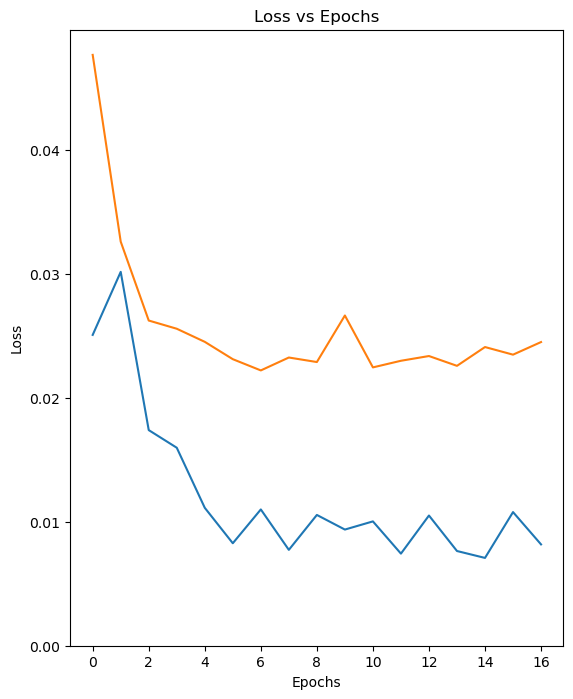

In [82]:
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Loss vs Epochs')
plt.show()

In [83]:
loss=model.evaluate(X_test,y_test,batch_size=1)
print(f"Test Loss: {loss:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211
Test Loss: 0.0245


In [85]:
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)
train_pred=sc_train.inverse_transform(train_pred)
test_pred=sc_test.inverse_transform(test_pred)
y_train=sc_train.inverse_transform(y_train)
y_test=sc_test.inverse_transform(y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [87]:
train_rmse= np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 24.7637
Test RMSE: 49.5983


In [89]:
train_prediction_df=result_df[lookback:pos]
train_prediction_df["predict"]= train_pred

train_prediction_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_13096\3490116713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prediction_df["predict"]= train_pred


,Pes,predict
Month,,
1949-02-01,118.0,133.744522
1949-03-01,132.0,136.890503
1949-04-01,129.0,146.044159
1949-05-01,121.0,143.689667
1949-06-01,135.0,138.495758


In [95]:
test_prediction_df=result_df[pos+lookback:]
test_prediction_df["predict"]= test_pred
test_prediction_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_13096\876219589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prediction_df["predict"]= test_pred


,Pes,predict
Month,,
1957-07-01,465.0,433.737640
1957-08-01,467.0,475.436920
1957-09-01,404.0,477.376465
1957-10-01,347.0,416.282043
1957-11-01,305.0,361.006226


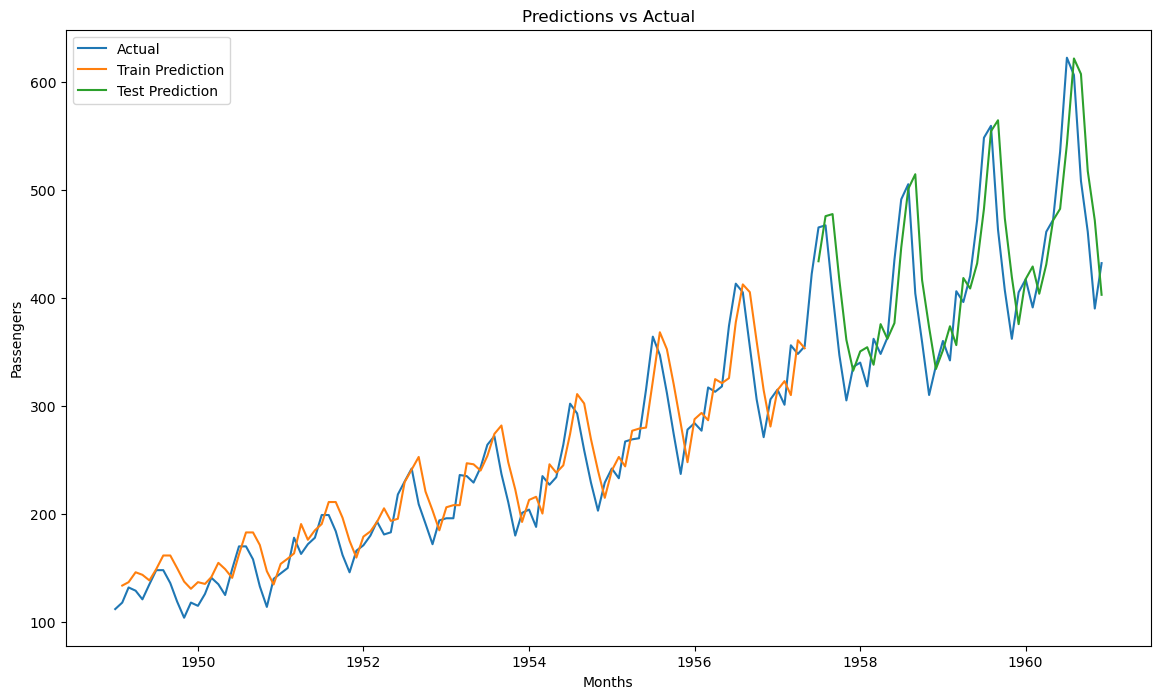

In [97]:
plt.figure(figsize=(14,8))
plt.plot(result_df, label='Actual')
plt.plot(train_prediction_df['predict'], label='Train Prediction')
plt.plot(test_prediction_df['predict'], label='Test Prediction')
plt.title('Predictions vs Actual')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.legend()
plt.show()